In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display

In [66]:
# source of Une Barque sur l'Ocean (piano piece by Maurice Ravel):
# http://ks4.imslp.net/files/imglnks/usimg/c/cc/IMSLP75355-PMLP04225-Maurice_Ravel_-_Une_barque_sur_l'ocean_-_Karstein_Djupdal_2008.mp3

# source of Angry Birds Theme Song:
# https://www.youtube.com/watch?v=DehK_Y0TUbE

# source of Sweet Home Alabama:
# https://youtube.com/watch?v=ye5BuYf8q4o

In [104]:
# class that uses the librosa library to analyze the key that an mp3 is in
# arguments:
#     waveform: an mp3 file loaded by librosa, ideally separated out from any percussive sources
#     sr: sampling rate of the mp3, which can be obtained when the file is read with librosa
#     tstart and tend: the range in seconds of the file to be analyzed; default to the beginning and end of file if not specified
class Tonal_Fragment(object):
    def __init__(self, waveform, sr, tstart=None, tend=None):
        self.waveform = waveform
        self.sr = sr
        self.tstart = tstart
        self.tend = tend
        
        if self.tstart is not None:
            self.tstart = librosa.time_to_samples(self.tstart, sr=self.sr)
        if self.tend is not None:
            self.tend = librosa.time_to_samples(self.tend, sr=self.sr)
        self.y_segment = self.waveform[self.tstart:self.tend]
        self.chromograph = librosa.feature.chroma_cqt(y=self.y_segment, sr=self.sr, bins_per_octave=24)
        
        # chroma_vals is the amount of each pitch class present in this time interval
        self.chroma_vals = []
        for i in range(12):
            self.chroma_vals.append(np.sum(self.chromograph[i]))
        pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        keys = [pitches[i] + ' major' for i in range(12)] + [pitches[i] + ' minor' for i in range(12)]
        # dictionary relating pitch names to the associated intensity in the song
        self.keyfreqs = {pitches[i]: self.chroma_vals[i] for i in range(12)} 

        # use of the Krumhansl-Schmuckler key-finding algorithm, which compares the chroma
        # data above to typical profiles of major and minor keys:
        maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
        min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

        # finds correlations between the amount of each pitch class in the time interval and the above profiles,
        # starting on each of the 12 pitches. then creates dict of the musical keys (major/minor) to the correlation
        self.min_key_corrs = []
        self.maj_key_corrs = []
        for i in range(12):
            key_test = [self.keyfreqs.get(pitches[(i + m)%12]) for m in range(12)]
            # correlation coefficients (strengths of correlation for each key)
            self.maj_key_corrs.append(round(np.corrcoef(maj_profile, key_test)[1,0], 3))
            self.min_key_corrs.append(round(np.corrcoef(min_profile, key_test)[1,0], 3))

        # names of all major and minor keys
        self.key_dict = {**{keys[i]: self.maj_key_corrs[i] for i in range(12)}, 
                         **{keys[i+12]: self.min_key_corrs[i] for i in range(12)}}
        
        # this attribute represents the key determined by the algorithm
        self.key = max(self.key_dict, key=self.key_dict.get)
        self.bestcorr = max(self.key_dict.values())
        
        # this attribute represents the second-best key determined by the algorithm,
        # if the correlation is close to that of the actual key determined
        self.altkey = None
        self.altbestcorr = None

        for key, corr in self.key_dict.items():
            if corr > self.bestcorr*0.9 and corr != self.bestcorr:
                self.altkey = key
                self.altbestcorr = corr
                
    # prints the correlation coefficients associated with each major/minor key
    def corr_table(self):
        for key, corr in self.key_dict.items():
            print(key, '\t', f'{corr:6.3f}')
    
    # printout of the key determined by the algorithm; if another key is close, that key is mentioned
    def print_key(self):
        print("likely key: ", max(self.key_dict, key=self.key_dict.get), ", correlation: ", self.bestcorr, sep='')
        if self.altkey is not None:
                print("also possible: ", self.altkey, ", correlation: ", self.altbestcorr, sep='')
    
    # prints a chromagram of the file, showing the intensity of each pitch class over time
    def chromagram(self, title=None):
        C = librosa.feature.chroma_cqt(y=self.waveform, sr=sr, bins_per_octave=24)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
        if title is None:
            plt.title('Chromagram')
        else:
            plt.title(title)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

In [117]:
# this audio takes a long time to load because it has a very high sampling rate; be patient.
audio_path = 'une-barque-sur-l\'ocean.mp3'
# the load function generates a tuple consisting of an audio object y and its sampling rate sr
y, sr = librosa.load(audio_path)
# this function filters out the harmonic part of the sound file from the percussive part, allowing for
# more accurate harmonic analysis
y_harmonic, y_percussive = librosa.effects.hpss(y)
ipd.Audio(audio_path)

likely key: F# minor, correlation: 0.762
C major 	 -0.318
C# major 	  0.543
D major 	  0.285
D# major 	 -0.572
E major 	  0.179
F major 	 -0.396
F# major 	  0.524
G major 	 -0.154
G# major 	 -0.175
A major 	  0.474
A# major 	 -0.473
B major 	  0.083
C minor 	 -0.596
C# minor 	  0.630
D minor 	 -0.087
D# minor 	 -0.073
E minor 	 -0.110
F minor 	 -0.155
F# minor 	  0.762
G minor 	 -0.313
G# minor 	 -0.158
A minor 	 -0.222
A# minor 	  0.192
B minor 	  0.131


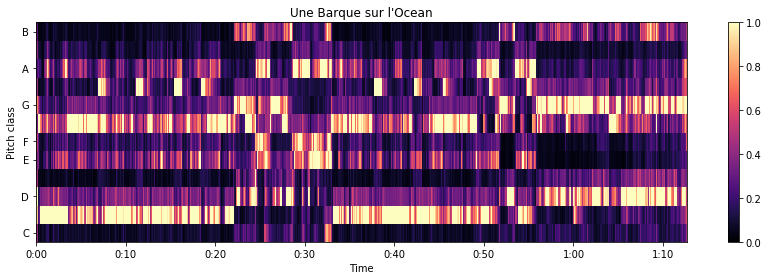

In [118]:
# this block instantiates the Tonal_Fragment class with the first 22 seconds of the above harmonic part of une barque.
# the three methods called will print the determined key of the song, the correlation coefficients for all keys,
# and a chromogram, which shows the intensity of frequencies associated with each of the 12 pitch classes over time.

unebarque_fsharp_maj = Tonal_Fragment(y_harmonic, sr, tend=22)
unebarque_fsharp_maj.print_key()
unebarque_fsharp_maj.corr_table()
unebarque_fsharp_maj.chromagram("Une Barque sur l\'Ocean")

In [ ]:
# parts of the song that are more tonally ambiguous will show two keys with print_key(),
# if they are similarly well-correlated.
# this section of une barque is in E minor, though the algorithm suggests that it is in D major, a closely related key,
# though E minor is also listed since their correlation coefficients are very close.
unebarque_e_min = Tonal_Fragment(y_harmonic, sr, tstart=22, tend=33)
unebarque_e_min.print_key()
unebarque_e_min.corr_table()

In [110]:
# in the case of une barque sur l'ocean (and other songs), predictions become less reliable over short time frames
# the below block prints the predicted key of every 3-second-long cut of the piece.
bin_size = 3
for i in range(24):
    fragment = Tonal_Fragment(y_harmonic, sr, tstart = bin_size*i, tend=bin_size*(i+1))
    print(bin_size*i,"sec:",fragment.key)
    if fragment.altkey is not None:
        print("\t or:", fragment.altkey)

0 sec: F# minor
3 sec: F# minor
6 sec: F# minor
9 sec: F# minor
	 or: C# minor
12 sec: F# minor
	 or: C# minor
15 sec: C# minor
	 or: F# minor
18 sec: F# minor
21 sec: B minor
	 or: G major
24 sec: D major
	 or: E minor
27 sec: D major
30 sec: A minor
33 sec: F# minor
36 sec: F# minor
	 or: C# minor
39 sec: F# minor
42 sec: C# minor
45 sec: F# minor
48 sec: F# minor
	 or: C# minor
51 sec: D major
54 sec: F# minor
	 or: A major
57 sec: G major
60 sec: G major
63 sec: G major
	 or: D major
66 sec: G major
	 or: D major
69 sec: G major


likely key: G major, correlation: 0.801
C major 	  0.356
C# major 	 -0.497
D major 	  0.649
D# major 	  0.120
E major 	 -0.407
F major 	  0.027
F# major 	 -0.520
G major 	  0.801
G# major 	 -0.180
A major 	 -0.029
A# major 	  0.109
B major 	 -0.429
C minor 	  0.325
C# minor 	 -0.435
D minor 	  0.438
D# minor 	 -0.304
E minor 	  0.223
F minor 	 -0.285
F# minor 	 -0.129
G minor 	  0.654
G# minor 	 -0.297
A minor 	  0.070
A# minor 	 -0.559
B minor 	  0.300


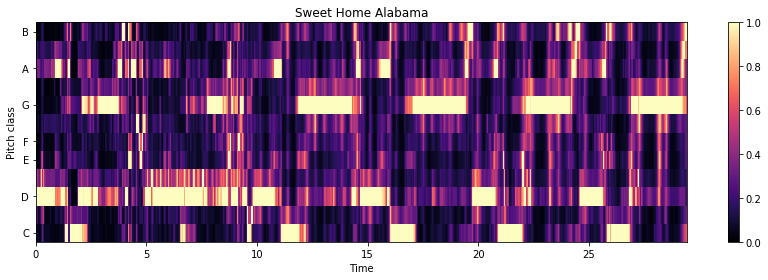

In [114]:
# lynyrd skynyrd's "sweet home alabama" is a song famously contentious among music theorists due to its ambiguous key;
# it is oft debated whether it is in G major or D major. in this instance, the algorithm chooses G major over D major 
# by a wide margin, not even reporting D major as a possible alternative. this is just one example of the human ear's
# impression disagreeing with this simple algorithm.

audio_path = 'sweet-home-alabama.mp3'
y, sr = librosa.load(audio_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

song = Tonal_Fragment(y_harmonic, sr)
song.print_key()
song.corr_table()
song.chromagram("Sweet Home Alabama")

In [102]:
ipd.Audio(audio_path)

likely key: E minor, correlation: 0.665
C major 	  0.264
C# major 	 -0.517
D major 	 -0.030
D# major 	 -0.270
E major 	  0.490
F major 	 -0.064
F# major 	 -0.183
G major 	  0.323
G# major 	 -0.355
A major 	  0.010
A# major 	 -0.190
B major 	  0.522
C minor 	  0.009
C# minor 	 -0.049
D minor 	 -0.123
D# minor 	 -0.086
E minor 	  0.665
F minor 	 -0.222
F# minor 	 -0.317
G minor 	 -0.270
G# minor 	  0.204
A minor 	  0.139
A# minor 	 -0.438
B minor 	  0.487


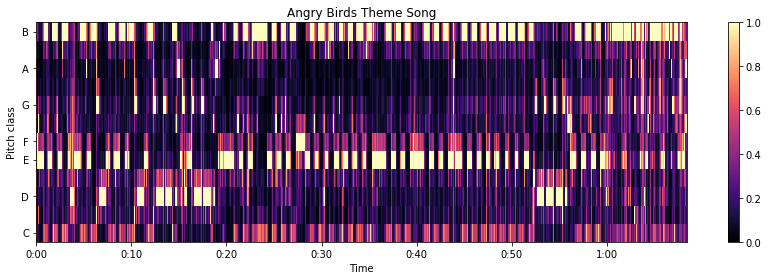

In [115]:
# the Angry Birds theme song is another song that can be analyzed correctly by the algorithm.
# the whole piece is in E minor, in agreement with the result below.

audio_path = 'angry-birds-theme-song.mp3'
y, sr = librosa.load(audio_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

angry_birds_e_min = Tonal_Fragment(y_harmonic, sr, tstart=0.4)
angry_birds_e_min.print_key()
angry_birds_e_min.corr_table()
angry_birds_e_min.chromagram("Angry Birds Theme Song")

In [116]:
ipd.Audio(audio_path)